# Multi-Objective Bayesian Optimization for HierarchicalPredictionNet Neural Network

This notebook implements multi-objective Bayesian optimization using Ax and BoTorch for hyperparameter tuning of a HierarchicalPredictionNet model for mass spectrometry prediction.

## Mathematical Framework

### Multi-Objective Optimization Problem

We solve the multi-objective optimization problem:

$$\mathbf{x}^* = \arg\max_{\mathbf{x} \in \mathcal{X}} [f_1(\mathbf{x}), -f_2(\mathbf{x})]$$

Where:
- $f_1(\mathbf{x})$ = Cosine similarity (maximize)
- $f_2(\mathbf{x})$ = RMSE (minimize, hence negated)
- $\mathcal{X}$ = Hyperparameter search space

### HierarchicalPredictionNet Architecture

HierarchicalPredictionNet uses a two-stage hierarchical approach:

**Stage 1 - Presence Prediction:**
$$p_{presence} = \sigma(f_{presence}(x))$$

**Stage 2 - Intensity Prediction (conditioned on presence):**
$$y_{intensity} = f_{intensity}([x, p_{presence}])$$

### Batch Acquisition Function

We use qNEHVI (quasi-Noisy Expected Hypervolume Improvement) for batch acquisition:

$$\alpha_{qNEHVI}(\mathbf{X}) = \mathbb{E}[HV(\mathcal{P} \cup f(\mathbf{X})) - HV(\mathcal{P})]$$

Where $\mathcal{P}$ is the current Pareto frontier and $HV$ is the hypervolume indicator.

## 1. Environment Setup and Thread Control

Set environment variables before importing numerical libraries to prevent thread oversubscription.

In [1]:
# Prevent thread oversubscription for parallel processing
import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

import json
import pickle
import warnings
import logging
from typing import Dict, Any, Tuple, List, Optional, Union
from datetime import datetime
from dataclasses import dataclass, field
from pathlib import Path
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Force CPU usage for torch (MPS doesn't work with BoTorch)
torch.set_default_device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(-1)  # Disable CUDA

# Device for neural network training
if torch.backends.mps.is_available():
    NN_DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    NN_DEVICE = torch.device("cuda")
else:
    NN_DEVICE = torch.device("cpu")
    
# Ax and BoTorch imports
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Generators
from ax.core.optimization_config import MultiObjectiveOptimizationConfig
from ax.core.objective import MultiObjective, Objective
from ax.core.metric import Metric
from ax.core.outcome_constraint import ObjectiveThreshold
from ax.core.types import ComparisonOp

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

logger.info(f"Environment setup complete. CPU count: {os.cpu_count()}")
logger.info(f"BoTorch will run on CPU (required for stability)")
logger.info(f"Neural networks will train on: {NN_DEVICE}")

[WARNING 08-25 16:53:41] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.
/var/folders/_g/yv_ycc0s11z1x8zk__56l6r80000gn/T/ipykernel_39079/1290564398.py:53: DeprecationWarning: Please import from 'ax.generation_strategy.generation_strategy' instead of 'ax.modelbridge.generation_strategy'. The latter is deprecated and will be removed in a future release.
  from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
2025-08-25 16:53:41,923 - INFO - Environment setup complete. CPU count: 16
2025-08-25 16:53:41,938 - INFO - BoTorch will run on CPU (required for stability)
2025-08-25 16:53:41,941 - INFO - Neural networks will train on: mps


## 2. Configuration Dataclass

Using dataclasses for clean configuration management following SOLID principles.

In [2]:
@dataclass
class OptimizationConfig:
    """Configuration for HierarchicalPredictionNet Bayesian optimization."""
    # Data paths
    results_dir: Path = Path('../data/results')
    models_dir: Path = Path('../models/hierarchical_bayesian_optimized')
    input_type: str = 'hpj'
    use_selected_data: bool = False
    
    # Data processing
    transform_sqrt: bool = True
    validation_split: float = 0.2
    random_state: int = 42
    
    # Optimization settings
    n_iterations: int = 50
    n_initial_points: int = 14  # Sobol initialization
    batch_size: int = 4  # Smaller batches for NN training
    
    # Speed optimization
    row_subsample_frac: float = 0.3  # Subsample for faster evaluation
    max_bins_eval: int = 512  # Limit bins for evaluation
    max_epochs_eval: int = 30  # Limit epochs during optimization
    max_epochs_final: int = 100  # More epochs for final training
    
    # Multi-objective settings
    objectives: List[str] = field(default_factory=lambda: ['cosine_similarity', 'rmse'])
    minimize: List[bool] = field(default_factory=lambda: [False, True])
    
    # Neural network training
    early_stopping_patience: int = 10
    min_batch_size: int = 16  # Minimum batch size for BatchNorm
    max_batch_size: int = 256  # Maximum batch size
    
    def __post_init__(self):
        self.models_dir.mkdir(parents=True, exist_ok=True)
        
    @property
    def data_dir(self) -> Path:
        subdir = 'selected' if self.use_selected_data else 'full_featurised'
        return self.results_dir / self.input_type / subdir
    
    def get_data_paths(self) -> Dict[str, Path]:
        return {
            'train': self.data_dir / 'train_data.jsonl',
            'val': self.data_dir / 'val_data.jsonl',
            'test': self.data_dir / 'test_data.jsonl'
        }

config = OptimizationConfig()

## 3. Data Loading and Preprocessing

Efficient data loading with vectorized operations and proper scaler management.

In [3]:
class DataLoader:
    """Handles data loading and preprocessing."""
    
    @staticmethod
    def load_jsonl(filepath: Path) -> Tuple[List[str], np.ndarray, np.ndarray]:
        """Load data from JSONL file."""
        if not filepath.exists():
            raise FileNotFoundError(f"File not found: {filepath}")
        
        data = []
        with open(filepath, 'r') as f:
            for line in tqdm(f, desc=f"Loading {filepath.name}"):
                try:
                    record = json.loads(line)
                    if all(k in record for k in ['smiles', 'features', 'target']):
                        data.append(record)
                except json.JSONDecodeError:
                    continue
        
        if not data:
            raise ValueError(f"No valid data in {filepath}")
        
        smiles = [d['smiles'] for d in data]
        features = np.array([d['features'] for d in data])
        targets = np.array([d['target'] for d in data])
        
        logger.info(f"Loaded {len(smiles)} samples from {filepath.name}")
        return smiles, features, targets
    
    @staticmethod
    def prepare_data(config: OptimizationConfig) -> Dict[str, Any]:
        """Load and prepare all data using existing train/val/test splits."""
        paths = config.get_data_paths()
        
        # Load all three splits
        train_smiles, X_train, y_train = DataLoader.load_jsonl(paths['train'])
        val_smiles, X_val, y_val = DataLoader.load_jsonl(paths['val'])
        test_smiles, X_test, y_test = DataLoader.load_jsonl(paths['test'])
        
        # Apply transformation
        if config.transform_sqrt:
            y_train = np.sqrt(np.maximum(y_train, 0))
            y_val = np.sqrt(np.maximum(y_val, 0))
            y_test = np.sqrt(np.maximum(y_test, 0))
        
        # Create subsampled indices for fast evaluation during optimization
        rng = np.random.RandomState(config.random_state)
        n_subsample = int(len(X_val) * config.row_subsample_frac)
        row_idx = rng.choice(len(X_val), n_subsample, replace=False)
        bin_idx = slice(None, min(config.max_bins_eval, y_val.shape[1]))
        
        # Scale features for optimization - fit on train, apply to val
        opt_scaler = StandardScaler()
        X_train_scaled = opt_scaler.fit_transform(X_train)
        X_val_scaled = opt_scaler.transform(X_val)
        
        # Subsampled validation data for fast evaluation
        X_val_sub = X_val_scaled[row_idx]
        y_val_sub = y_val[row_idx][:, bin_idx]
        
        # Subsampled training data for fast evaluation
        n_train_sub = int(len(X_train) * config.row_subsample_frac)
        train_row_idx = rng.choice(len(X_train), n_train_sub, replace=False)
        X_train_sub = X_train_scaled[train_row_idx]
        y_train_sub = y_train[train_row_idx][:, bin_idx]
        
        # Separate scaler for final training (refit on full train for final model)
        final_scaler = StandardScaler()
        X_train_final = final_scaler.fit_transform(X_train)
        X_test_scaled = final_scaler.transform(X_test)
        
        return {
            'X_opt_train': X_train_scaled,  # For optimization
            'X_opt_val': X_val_scaled,      # Full validation
            'y_opt_train': y_train,
            'y_opt_val': y_val,
            'X_opt_train_sub': X_train_sub, # Subsampled training
            'y_opt_train_sub': y_train_sub,
            'X_opt_val_sub': X_val_sub,     # Subsampled validation
            'y_opt_val_sub': y_val_sub,
            'X_train': X_train_final,       # For final training
            'X_test': X_test_scaled,        # For final evaluation
            'y_train': y_train,
            'y_val': y_val,                 # Keep original val
            'y_test': y_test,
            'opt_scaler': opt_scaler,
            'final_scaler': final_scaler,
            'bin_idx': bin_idx
        }

# Load data
data = DataLoader.prepare_data(config)
logger.info(f"Data shapes - Train: {data['X_opt_train'].shape}, Val: {data['X_opt_val'].shape}, Test: {data['X_test'].shape}")
logger.info(f"Subsampled train for fast eval: {data['X_opt_train_sub'].shape}")
logger.info(f"Subsampled val for fast eval: {data['X_opt_val_sub'].shape}")

Loading train_data.jsonl: 0it [00:00, ?it/s]

2025-08-25 16:53:49,012 - INFO - Loaded 2176 samples from train_data.jsonl


Loading val_data.jsonl: 0it [00:00, ?it/s]

2025-08-25 16:53:49,999 - INFO - Loaded 272 samples from val_data.jsonl


Loading test_data.jsonl: 0it [00:00, ?it/s]

2025-08-25 16:53:50,576 - INFO - Loaded 272 samples from test_data.jsonl
2025-08-25 16:53:50,995 - INFO - Data shapes - Train: (2176, 7137), Val: (272, 7137), Test: (272, 7137)
2025-08-25 16:53:50,996 - INFO - Subsampled train for fast eval: (652, 7137)
2025-08-25 16:53:50,997 - INFO - Subsampled val for fast eval: (81, 7137)


## 4. Metrics Computation

Vectorized metrics computation for efficiency, including hierarchical metrics.

In [4]:
class MetricsComputer:
    """Compute evaluation metrics including hierarchical metrics."""
    
    @staticmethod
    def cosine_similarity(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Compute mean cosine similarity."""
        # Vectorized cosine similarity
        dot_product = np.sum(y_true * y_pred, axis=1)
        norm_true = np.linalg.norm(y_true, axis=1)
        norm_pred = np.linalg.norm(y_pred, axis=1)
        
        # Avoid division by zero
        valid_mask = (norm_true > 0) & (norm_pred > 0)
        similarities = np.zeros(len(y_true))
        similarities[valid_mask] = dot_product[valid_mask] / (norm_true[valid_mask] * norm_pred[valid_mask])
        
        return float(np.mean(similarities))
    
    @staticmethod
    def presence_accuracy(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.01) -> float:
        """Calculate presence prediction accuracy."""
        true_presence = y_true > threshold
        pred_presence = y_pred > threshold
        return float(np.mean(true_presence == pred_presence))
    
    @staticmethod
    def conditional_mse(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.01) -> float:
        """Calculate MSE only on positions where true peaks exist."""
        mask = y_true > threshold
        if np.sum(mask) == 0:
            return 0.0
        return float(mean_squared_error(y_true[mask], y_pred[mask]))
    
    @staticmethod
    def compute_all_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Compute all evaluation metrics."""
        return {
            'cosine_similarity': MetricsComputer.cosine_similarity(y_true, y_pred),
            'rmse': float(np.sqrt(mean_squared_error(y_true, y_pred))),
            'mae': float(mean_absolute_error(y_true, y_pred)),
            'r2': float(r2_score(y_true, y_pred)),
            'presence_accuracy': MetricsComputer.presence_accuracy(y_true, y_pred),
            'conditional_mse': MetricsComputer.conditional_mse(y_true, y_pred)
        }

## 5. HierarchicalPredictionNet Architecture

Define the neural network architecture with hierarchical prediction.

### Architecture Components:

1. **Stage 1 - Presence Network**: Predicts whether a peak exists at each position
2. **Stage 2 - Intensity Network**: Predicts peak intensities conditioned on presence
3. **Calibration Layer**: Fine-tunes the final predictions

In [5]:
# Activation function mapping
ACTIVATION_FUNCTIONS = {
    'relu': nn.ReLU,
    'elu': nn.ELU,
    'gelu': nn.GELU,
    'selu': nn.SELU
}

class HierarchicalPredictionNet(nn.Module):
    """HierarchicalPredictionNet with configurable architecture."""
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        # Extract configuration
        presence_layers = config['presence_layers']
        presence_hidden = config['presence_hidden']
        presence_dropout = config.get('presence_dropout', 0.1)
        
        intensity_layers = config['intensity_layers']
        intensity_hidden = config['intensity_hidden']
        conditional_dropout = config.get('conditional_dropout', 0.2)
        
        activation = config.get('activation', 'relu')
        use_batch_norm = config.get('use_batch_norm', True)
        use_calibration = config.get('use_calibration', True)
        self.presence_threshold = config.get('presence_threshold', 0.01)
        
        activation_fn = ACTIVATION_FUNCTIONS[activation]
        
        # Stage 1: Presence prediction network
        presence_net_layers = []
        current_dim = input_dim
        
        for i in range(presence_layers):
            presence_net_layers.append(nn.Linear(current_dim, presence_hidden))
            if use_batch_norm:
                presence_net_layers.append(nn.BatchNorm1d(presence_hidden))
            presence_net_layers.append(activation_fn())
            presence_net_layers.append(nn.Dropout(presence_dropout))
            current_dim = presence_hidden
        
        presence_net_layers.append(nn.Linear(presence_hidden, output_dim))
        self.presence_net = nn.Sequential(*presence_net_layers)
        
        # Stage 2: Intensity prediction network (conditioned on presence)
        intensity_input_dim = input_dim + output_dim  # Concatenate input with presence predictions
        intensity_net_layers = []
        current_dim = intensity_input_dim
        
        for i in range(intensity_layers):
            intensity_net_layers.append(nn.Linear(current_dim, intensity_hidden))
            if use_batch_norm:
                intensity_net_layers.append(nn.BatchNorm1d(intensity_hidden))
            intensity_net_layers.append(activation_fn())
            intensity_net_layers.append(nn.Dropout(conditional_dropout))
            current_dim = intensity_hidden
        
        intensity_net_layers.append(nn.Linear(intensity_hidden, output_dim))
        intensity_net_layers.append(nn.ReLU())  # Ensure non-negative intensities
        self.intensity_net = nn.Sequential(*intensity_net_layers)
        
        # Calibration layer (optional)
        self.use_calibration = use_calibration
        if use_calibration:
            self.calibration = nn.Sequential(
                nn.Linear(output_dim, output_dim),
                nn.Sigmoid()
            )
    
    def forward(self, x, return_presence=False):
        # Stage 1: Predict presence
        presence_logits = self.presence_net(x)
        presence_probs = torch.sigmoid(presence_logits)
        
        # Stage 2: Predict intensities conditioned on presence
        conditional_input = torch.cat([x, presence_probs], dim=1)
        intensities = self.intensity_net(conditional_input)
        
        # Apply calibration if enabled
        if self.use_calibration:
            calibration_weights = self.calibration(intensities)
            output = intensities * presence_probs * calibration_weights
        else:
            output = intensities * presence_probs
        
        if return_presence:
            return output, presence_logits
        return output

def create_optimizer(model, params):
    """Create optimizer based on parameters."""
    optimizer_name = params.get('optimizer', 'adam')
    lr = params['learning_rate']
    weight_decay = params.get('weight_decay', 0.0)
    
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'adamw':
        return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, 
                              momentum=0.9, nesterov=True)
    else:
        return torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

## 6. Search Space Definition

Define the hyperparameter search space for HierarchicalPredictionNet.

### Search Space Design:

The search space is designed to optimize the two-stage hierarchical architecture:

- **Presence Network**: Layers, hidden units, dropout
- **Intensity Network**: Layers, hidden units, dropout
- **Training Parameters**: Learning rate, batch size, optimizer, weight decay
- **Architecture Features**: Activation, batch norm, calibration

In [6]:
def create_search_space() -> List[Dict[str, Any]]:
    """Create Ax search space for HierarchicalPredictionNet."""
    return [
        # Presence network architecture
        {
            "name": "presence_layers",
            "type": "range",
            "bounds": [1, 4],
            "value_type": "int"
        },
        {
            "name": "presence_hidden",
            "type": "range",
            "bounds": [32, 512],
            "value_type": "int",
            "log_scale": True
        },
        {
            "name": "presence_dropout",
            "type": "range",
            "bounds": [0.0, 0.5],
            "value_type": "float"
        },
        # Intensity network architecture
        {
            "name": "intensity_layers",
            "type": "range",
            "bounds": [1, 5],
            "value_type": "int"
        },
        {
            "name": "intensity_hidden",
            "type": "range",
            "bounds": [64, 1024],
            "value_type": "int",
            "log_scale": True
        },
        {
            "name": "conditional_dropout",
            "type": "range",
            "bounds": [0.0, 0.6],
            "value_type": "float"
        },
        # Shared architecture parameters
        {
            "name": "activation",
            "type": "choice",
            "values": ["relu", "elu", "gelu", "selu"],
            "value_type": "str"
        },
        {
            "name": "use_batch_norm",
            "type": "choice",
            "values": [True, False],
            "value_type": "bool"
        },
        {
            "name": "use_calibration",
            "type": "choice",
            "values": [True, False],
            "value_type": "bool"
        },
        {
            "name": "presence_threshold",
            "type": "range",
            "bounds": [0.001, 0.1],
            "value_type": "float",
            "log_scale": True
        },
        # Training parameters
        {
            "name": "learning_rate",
            "type": "range",
            "bounds": [1e-5, 1e-2],
            "value_type": "float",
            "log_scale": True
        },
        {
            "name": "batch_size",
            "type": "choice",
            "values": [16, 32, 64, 128, 256],
            "value_type": "int"
        },
        {
            "name": "optimizer",
            "type": "choice",
            "values": ["adam", "adamw", "sgd", "rmsprop"],
            "value_type": "str"
        },
        {
            "name": "weight_decay",
            "type": "range",
            "bounds": [0.0, 0.1],
            "value_type": "float"
        },
        {
            "name": "gradient_clip",
            "type": "range",
            "bounds": [0.0, 5.0],
            "value_type": "float"
        }
    ]

## 7. Evaluation Function

The evaluation function trains a HierarchicalPredictionNet model and returns multiple objectives.
Uses subsampled data for faster evaluation during optimization.

In [7]:
def train_and_evaluate_nn(parameters: Dict[str, Any], data: Dict[str, np.ndarray], 
                          config: OptimizationConfig, use_subsample: bool = True) -> Dict[str, Tuple[float, float]]:
    """Train and evaluate HierarchicalPredictionNet with given parameters.
    
    Args:
        parameters: Hyperparameters to evaluate
        data: Data dictionary
        config: Optimization configuration
        use_subsample: Whether to use subsampled data for faster evaluation
    
    Returns:
        dict with cosine_similarity and rmse (mean, sem) tuples
    """
    # Select appropriate data
    if use_subsample:
        X_train = data['X_opt_train_sub']
        y_train = data['y_opt_train_sub']
        X_val = data['X_opt_val_sub']
        y_val = data['y_opt_val_sub']
        max_epochs = config.max_epochs_eval
    else:
        X_train = data['X_opt_train']
        y_train = data['y_opt_train'][:, data['bin_idx']] if use_subsample else data['y_opt_train']
        X_val = data['X_opt_val']
        y_val = data['y_opt_val'][:, data['bin_idx']] if use_subsample else data['y_opt_val']
        max_epochs = config.max_epochs_final
    
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    
    # Create model
    model = HierarchicalPredictionNet(input_dim, output_dim, parameters).to(NN_DEVICE)
    optimizer = create_optimizer(model, parameters)
    
    # Create data loaders
    batch_size = min(parameters['batch_size'], len(X_train) // 2)
    batch_size = max(batch_size, config.min_batch_size)  # Ensure minimum for BatchNorm
    
    train_dataset = TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(y_train).float()
    )
    val_dataset = TensorDataset(
        torch.from_numpy(X_val).float(),
        torch.from_numpy(y_val).float()
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False
    )
    
    # Training loop
    best_val_cosine = -1.0
    patience_counter = 0
    gradient_clip = parameters.get('gradient_clip', 0.0)
    
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_losses = []
        
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(NN_DEVICE)
            y_batch = y_batch.to(NN_DEVICE)
            
            optimizer.zero_grad()
            predictions, presence_logits = model(x_batch, return_presence=True)
            
            # Compute losses
            mse_loss = F.mse_loss(predictions, y_batch)
            presence_true = (y_batch > parameters['presence_threshold']).float()
            presence_loss = F.binary_cross_entropy_with_logits(presence_logits, presence_true)
            
            total_loss = mse_loss + 0.1 * presence_loss  # Simple weighting
            total_loss.backward()
            
            if gradient_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            
            optimizer.step()
            train_losses.append(total_loss.item())
        
        # Validation
        model.eval()
        val_predictions = []
        val_targets = []
        
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(NN_DEVICE)
                predictions = model(x_batch)
                val_predictions.append(predictions.cpu().numpy())
                val_targets.append(y_batch.numpy())
        
        val_pred = np.vstack(val_predictions)
        val_true = np.vstack(val_targets)
        val_pred = np.maximum(val_pred, 0)  # Ensure non-negative
        
        # Calculate metrics
        val_cosine = MetricsComputer.cosine_similarity(val_true, val_pred)
        
        # Early stopping
        if val_cosine > best_val_cosine:
            best_val_cosine = val_cosine
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config.early_stopping_patience:
                break
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.from_numpy(X_val).float().to(NN_DEVICE)
        y_pred = model(X_val_tensor).cpu().numpy()
        y_pred = np.maximum(y_pred, 0)
    
    metrics = MetricsComputer.compute_all_metrics(y_val, y_pred)
    
    return {
        'cosine_similarity': (metrics['cosine_similarity'], 0.0),
        'rmse': (metrics['rmse'], 0.0)
    }

# Note: Neural network training is inherently sequential, so we won't use parallel evaluation
# But we can still benefit from batch acquisition in Ax

## 8. Multi-Objective Bayesian Optimization Setup

### Optimization Strategy

1. **Initialization Phase**: Use Sobol sequence for space-filling design
2. **Threshold Setting**: After initialization, set objective thresholds based on observed data
3. **Bayesian Phase**: Use NEHVI for multi-objective acquisition
4. **Sequential Evaluation**: Neural network training is sequential (no parallel evaluation)

The Pareto frontier $\mathcal{P}$ is updated after each evaluation.

In [8]:
# Initialize Ax client
ax_client = AxClient(verbose_logging=False)

# Create experiment with multi-objective optimization
ax_client.create_experiment(
    name="hierarchical_nn_multi_objective_optimization",
    parameters=create_search_space(),
    objectives={
        "cosine_similarity": ObjectiveProperties(minimize=False),
        "rmse": ObjectiveProperties(minimize=True)
    },
    overwrite_existing_experiment=True,
    immutable_search_space_and_opt_config=False,  # Allow config updates
)

# Define generation strategy for efficient optimization
gs = GenerationStrategy(
    steps=[
        # Sobol initialization for space exploration
        GenerationStep(
            model=Generators.SOBOL,
            num_trials=config.n_initial_points,
            min_trials_observed=config.n_initial_points
        ),
        # Multi-objective Bayesian optimization
        GenerationStep(
            model=Generators.BOTORCH_MODULAR,
            num_trials=-1,  # No limit
        )
    ]
)

ax_client._generation_strategy = gs

logger.info("Starting multi-objective Bayesian optimization for HierarchicalPredictionNet")
logger.info(f"Objectives: maximize cosine_similarity, minimize RMSE")
logger.info(f"Total trials: {config.n_iterations}")
logger.info(f"Neural network device: {NN_DEVICE}")

[WARNING 08-25 16:53:52] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-25 16:53:52] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 08-25 16:53:52] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 30 trials, BoTorch for subsequent trials]). Iterations after 30 will take longer to generate due to model-fitting.
2025-08-25 16:53:52,955 - INFO - Starting multi-objective Bayesian optimization for HierarchicalPredictionNet
2025-08-25 16:53:52,957 - INFO - Objectives: maximize cosine_similarity, minimize RMSE
2025-08-25 16:53:52,957 - INFO - Total trials: 50
2025-08-25 16:53:52,958 - INFO - Neural network device: mps


## 9. Optimization Loop

Run the optimization with two phases: Sobol initialization and Bayesian optimization.

In [9]:
# Storage for results
trials_data = []
best_cosine = -np.inf
best_rmse = np.inf

# Start optimization timer
optimization_start_time = time.time()

# Progress bar
pbar = tqdm(total=config.n_iterations, desc="Optimization Progress")

# Run all trials
for trial_index in range(config.n_iterations):
    # Generate next trial
    parameters, trial_id = ax_client.get_next_trial()
    
    # Determine which phase we're in
    phase = 'sobol' if trial_index < config.n_initial_points else 'bayesian'
    
    # Log current trial
    logger.info(f"\nTrial {trial_id} ({phase}): layers={parameters['presence_layers']}/{parameters['intensity_layers']}, "
                f"hidden={parameters['presence_hidden']}/{parameters['intensity_hidden']}, "
                f"lr={parameters['learning_rate']:.1e}")
    
    try:
        # Evaluate parameters
        start_time = time.time()
        raw_data = train_and_evaluate_nn(parameters, data, config, use_subsample=True)
        eval_time = time.time() - start_time
        
        # Complete trial
        ax_client.complete_trial(trial_index=trial_id, raw_data=raw_data)
        
        # Extract metrics
        cosine_sim = raw_data['cosine_similarity'][0]
        rmse = raw_data['rmse'][0]
        
        # Track results
        trial_data = {
            'trial_id': trial_id,
            'parameters': parameters,
            'cosine_similarity': cosine_sim,
            'rmse': rmse,
            'phase': phase,
            'eval_time': eval_time
        }
        trials_data.append(trial_data)
        
        # Update best values
        if cosine_sim > best_cosine:
            best_cosine = cosine_sim
            logger.info(f"  New best cosine: {best_cosine:.4f}")
        if rmse < best_rmse:
            best_rmse = rmse
            logger.info(f"  New best RMSE: {best_rmse:.4f}")
        
        # Update progress
        pbar.set_postfix({
            'Phase': phase,
            'Best Cosine': f'{best_cosine:.4f}',
            'Best RMSE': f'{best_rmse:.4f}',
            'Time': f'{eval_time:.1f}s'
        })
        
    except Exception as e:
        logger.error(f"Trial {trial_id} failed: {e}")
        ax_client.log_trial_failure(trial_index=trial_id)
    
    pbar.update(1)
    
    # Set objective thresholds after Sobol phase
    if trial_index == config.n_initial_points - 1:
        logger.info("\nSobol initialization complete. Setting objective thresholds...")
        
        # Compute thresholds from observed data
        df_sobol = pd.DataFrame(trials_data)
        cos_threshold = float(np.percentile(df_sobol["cosine_similarity"], 10))
        rmse_threshold = float(np.percentile(df_sobol["rmse"], 90))
        
        logger.info(f"Setting thresholds - Cosine >= {cos_threshold:.4f}, RMSE <= {rmse_threshold:.4f}")
        
        # Create metrics
        cosine_metric = Metric(name="cosine_similarity")
        rmse_metric = Metric(name="rmse")
        
        # Update optimization config with thresholds
        ax_client.experiment.optimization_config = MultiObjectiveOptimizationConfig(
            objective=MultiObjective(
                objectives=[
                    Objective(metric=cosine_metric, minimize=False),
                    Objective(metric=rmse_metric, minimize=True),
                ]
            ),
            objective_thresholds=[
                ObjectiveThreshold(
                    metric=cosine_metric,
                    bound=cos_threshold,
                    op=ComparisonOp.GEQ,
                    relative=False
                ),
                ObjectiveThreshold(
                    metric=rmse_metric,
                    bound=rmse_threshold,
                    op=ComparisonOp.LEQ,
                    relative=False
                ),
            ],
        )
        
        logger.info("Phase 2: Multi-objective Bayesian optimization with NEHVI")

pbar.close()

# Calculate total optimization time
optimization_time = time.time() - optimization_start_time

logger.info(f"\nOptimization complete in {optimization_time:.1f} seconds")
logger.info(f"Best cosine: {best_cosine:.4f}, Best RMSE: {best_rmse:.4f}")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-25 16:53:53,182 - INFO - 
Trial 0 (sobol): layers=1/5, hidden=213/184, lr=8.7e-03
2025-08-25 16:55:31,486 - INFO -   New best cosine: 0.6547
2025-08-25 16:55:31,487 - INFO -   New best RMSE: 0.1162
2025-08-25 16:55:31,500 - INFO - 
Trial 1 (sobol): layers=4/1, hidden=69/398, lr=3.1e-05
2025-08-25 16:55:40,872 - INFO - 
Trial 2 (sobol): layers=3/4, hidden=278/885, lr=5.7e-04
2025-08-25 16:55:52,219 - INFO - 
Trial 3 (sobol): layers=2/2, hidden=53/120, lr=6.8e-05
2025-08-25 16:56:30,045 - INFO - 
Trial 4 (sobol): layers=2/3, hidden=450/74, lr=1.4e-05
2025-08-25 16:56:41,025 - INFO - 
Trial 5 (sobol): layers=3/3, hidden=43/540, lr=4.0e-03
2025-08-25 16:56:45,750 - INFO - 
Trial 6 (sobol): layers=4/2, hidden=174/355, lr=1.4e-04
2025-08-25 16:56:53,631 - INFO - 
Trial 7 (sobol): layers=1/5, hidden=112/162, lr=1.2e-03
2025-08-25 16:57:31,866 - INFO -   New best cosine: 0.6717
2025-08-25 16:57:31,869 - INFO -   New best RMSE: 0.1151
2025-08-25 16:57:31,896 - INFO - 
Trial 8 (sobol): l

## 10. Extract Pareto Frontier

Use Ax's built-in Pareto utilities to identify optimal solutions.

In [10]:
# Get Pareto frontier using Ax utilities
try:
    pareto_results = ax_client.get_pareto_optimal_parameters()
    
    # Convert to DataFrame
    pareto_data = []
    for params, values_list in pareto_results.items():
        # Handle different return formats across Ax versions
        if isinstance(values_list, list) and len(values_list) > 0:
            values = values_list[0]
        else:
            values = values_list
        
        pareto_data.append({
            'parameters': dict(params),
            'cosine_similarity': values['cosine_similarity'],
            'rmse': values['rmse']
        })
    
    pareto_trials = pd.DataFrame(pareto_data)
    logger.info(f"Found {len(pareto_trials)} Pareto-optimal solutions (Ax method)")
    
except Exception as e:
    logger.warning(f"Ax Pareto extraction failed: {e}. Using manual method.")
    
    # Manual Pareto frontier extraction as fallback
    df_trials = pd.DataFrame(trials_data)
    
    def is_pareto_efficient(costs):
        """Find Pareto efficient points."""
        is_efficient = np.ones(costs.shape[0], dtype=bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                dominates = (costs[:, 0] >= c[0]) & (costs[:, 1] <= c[1])
                dominates[i] = False
                strict_dominates = dominates & ((costs[:, 0] > c[0]) | (costs[:, 1] < c[1]))
                if np.any(strict_dominates):
                    is_efficient[i] = False
        return is_efficient
    
    objectives = np.column_stack([
        df_trials['cosine_similarity'].values,
        df_trials['rmse'].values
    ])
    
    pareto_mask = is_pareto_efficient(objectives)
    pareto_trials = df_trials[pareto_mask].copy()
    logger.info(f"Found {len(pareto_trials)} Pareto-optimal solutions (manual method)")

print("\nPareto Frontier Solutions:")
if 'trial_id' in pareto_trials.columns:
    print(pareto_trials[['trial_id', 'cosine_similarity', 'rmse']].to_string(index=False))
else:
    print(pareto_trials[['cosine_similarity', 'rmse']].to_string(index=False))

2025-08-25 18:03:07,863 - WARNING - Ax Pareto extraction failed: 'int' object is not iterable. Using manual method.
2025-08-25 18:03:07,865 - INFO - Found 4 Pareto-optimal solutions (manual method)



Pareto Frontier Solutions:
 trial_id  cosine_similarity     rmse
       24           0.715696 0.114102
       31           0.713833 0.113724
       35           0.706447 0.112814
       37           0.712147 0.113258


## 11. Select Best Solution

Select the best solution from the Pareto frontier based on weighted preference.

In [11]:
# Convert trials to DataFrame if not already
df_trials = pd.DataFrame(trials_data)

# Select best solution based on weighted preference
weights = np.array([0.6, 0.4])  # [cosine, rmse]

# Extract objectives
objectives = np.column_stack([
    df_trials['cosine_similarity'].values,
    df_trials['rmse'].values
])

# Normalize objectives to [0, 1]
normalized_objectives = objectives.copy()
normalized_objectives[:, 0] = (objectives[:, 0] - objectives[:, 0].min()) / (objectives[:, 0].max() - objectives[:, 0].min() + 1e-8)
normalized_objectives[:, 1] = (objectives[:, 1].max() - objectives[:, 1]) / (objectives[:, 1].max() - objectives[:, 1].min() + 1e-8)

# Weighted sum
scores = normalized_objectives @ weights
best_idx = np.argmax(scores)
best_trial = df_trials.iloc[best_idx]

logger.info(f"\nBest solution (weighted):")
logger.info(f"  Cosine Similarity: {best_trial['cosine_similarity']:.6f}")
logger.info(f"  RMSE: {best_trial['rmse']:.6f}")
logger.info(f"  Parameters: {best_trial['parameters']}")

# Re-evaluate best parameters on full validation set for accurate metrics
logger.info("\nRe-evaluating best parameters on full validation set...")
full_eval = train_and_evaluate_nn(best_trial['parameters'], data, config, use_subsample=False)
logger.info(f"Full validation - Cosine: {full_eval['cosine_similarity'][0]:.6f}, RMSE: {full_eval['rmse'][0]:.6f}")

2025-08-25 18:03:07,908 - INFO - 
Best solution (weighted):
2025-08-25 18:03:07,908 - INFO -   Cosine Similarity: 0.712147
2025-08-25 18:03:07,909 - INFO -   RMSE: 0.113258
2025-08-25 18:03:07,910 - INFO -   Parameters: {'presence_layers': 4, 'presence_hidden': 32, 'presence_dropout': 0.5, 'intensity_layers': 1, 'intensity_hidden': 119, 'conditional_dropout': 0.19542212388281455, 'use_batch_norm': True, 'use_calibration': True, 'presence_threshold': 0.001, 'learning_rate': 0.0021956379338887704, 'batch_size': 16, 'weight_decay': 0.0, 'gradient_clip': 5.0, 'activation': 'gelu', 'optimizer': 'adamw'}
2025-08-25 18:03:07,910 - INFO - 
Re-evaluating best parameters on full validation set...
2025-08-25 18:18:36,743 - INFO - Full validation - Cosine: 0.766155, RMSE: 0.083018


## 12. Train Final Model

Train the final model using the selected hyperparameters on the full training set.

In [12]:
# Extract best parameters
best_params = best_trial['parameters']

# Train final model on full training data
logger.info("\nTraining final model on full dataset...")

# Create final model
final_model = HierarchicalPredictionNet(
    data['X_train'].shape[1],
    data['y_train'].shape[1],
    best_params
).to(NN_DEVICE)

final_optimizer = create_optimizer(final_model, best_params)

# Create data loaders for final training
batch_size = min(best_params['batch_size'], len(data['X_train']) // 2)
batch_size = max(batch_size, config.min_batch_size)

train_dataset = TensorDataset(
    torch.from_numpy(data['X_train']).float(),
    torch.from_numpy(data['y_train']).float()
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)

# Training loop
train_start = time.time()
best_train_loss = float('inf')
training_losses = []
gradient_clip = best_params.get('gradient_clip', 0.0)

for epoch in range(config.max_epochs_final):
    final_model.train()
    epoch_losses = []
    
    for x_batch, y_batch in train_loader:
        # Skip batch if it has only 1 sample (would break BatchNorm)
        if x_batch.size(0) == 1 and best_params.get('use_batch_norm', True):
            continue
            
        x_batch = x_batch.to(NN_DEVICE)
        y_batch = y_batch.to(NN_DEVICE)
        
        final_optimizer.zero_grad()
        predictions, presence_logits = final_model(x_batch, return_presence=True)
        
        # Compute losses
        mse_loss = F.mse_loss(predictions, y_batch)
        presence_true = (y_batch > best_params['presence_threshold']).float()
        presence_loss = F.binary_cross_entropy_with_logits(presence_logits, presence_true)
        
        total_loss = mse_loss + 0.1 * presence_loss
        total_loss.backward()
        
        if gradient_clip > 0:
            torch.nn.utils.clip_grad_norm_(final_model.parameters(), gradient_clip)
        
        final_optimizer.step()
        epoch_losses.append(total_loss.item())
    
    avg_epoch_loss = np.mean(epoch_losses)
    training_losses.append(avg_epoch_loss)
    
    # Early stopping based on training loss
    if avg_epoch_loss < best_train_loss:
        best_train_loss = avg_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 20:  # More patience for final training
            logger.info(f"Early stopping at epoch {epoch}")
            break
    
    if epoch % 10 == 0:
        logger.info(f"Epoch {epoch}: Loss = {avg_epoch_loss:.6f}")

train_time = time.time() - train_start

# Evaluate on test set
final_model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(data['X_test']).float().to(NN_DEVICE)
    y_test_pred = final_model(X_test_tensor).cpu().numpy()
    y_test_pred = np.maximum(y_test_pred, 0)

# Calculate test metrics
test_metrics = MetricsComputer.compute_all_metrics(data['y_test'], y_test_pred)

# Calculate model size
total_params = sum(p.numel() for p in final_model.parameters())
trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)

print("\nFinal Model Test Performance:")
print(f"  Cosine Similarity: {test_metrics['cosine_similarity']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE: {test_metrics['mae']:.6f}")
print(f"  R²: {test_metrics['r2']:.6f}")
print(f"  Presence Accuracy: {test_metrics['presence_accuracy']:.6f}")
print(f"  Conditional MSE: {test_metrics['conditional_mse']:.6f}")
print(f"\nModel Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Training time: {train_time:.1f}s")

2025-08-25 18:18:36,802 - INFO - 
Training final model on full dataset...
2025-08-25 18:18:45,193 - INFO - Epoch 0: Loss = 0.058074
2025-08-25 18:19:48,178 - INFO - Epoch 10: Loss = 0.034290
2025-08-25 18:20:50,995 - INFO - Epoch 20: Loss = 0.032809
2025-08-25 18:21:49,103 - INFO - Epoch 30: Loss = 0.032018
2025-08-25 18:22:48,576 - INFO - Epoch 40: Loss = 0.031628
2025-08-25 18:23:43,791 - INFO - Epoch 50: Loss = 0.031336
2025-08-25 18:24:34,114 - INFO - Epoch 60: Loss = 0.031046
2025-08-25 18:25:20,053 - INFO - Epoch 70: Loss = 0.030808
2025-08-25 18:26:06,465 - INFO - Epoch 80: Loss = 0.030282
2025-08-25 18:26:48,487 - INFO - Epoch 90: Loss = 0.030366



Final Model Test Performance:
  Cosine Similarity: 0.764745
  RMSE: 0.070186
  MAE: 0.024465
  R²: 0.192677
  Presence Accuracy: 0.869735
  Conditional MSE: 0.016516

Model Architecture:
  Total parameters: 1,468,000
  Trainable parameters: 1,468,000
  Training time: 530.6s


## 13. Visualization

Visualize the optimization results and Pareto frontier.

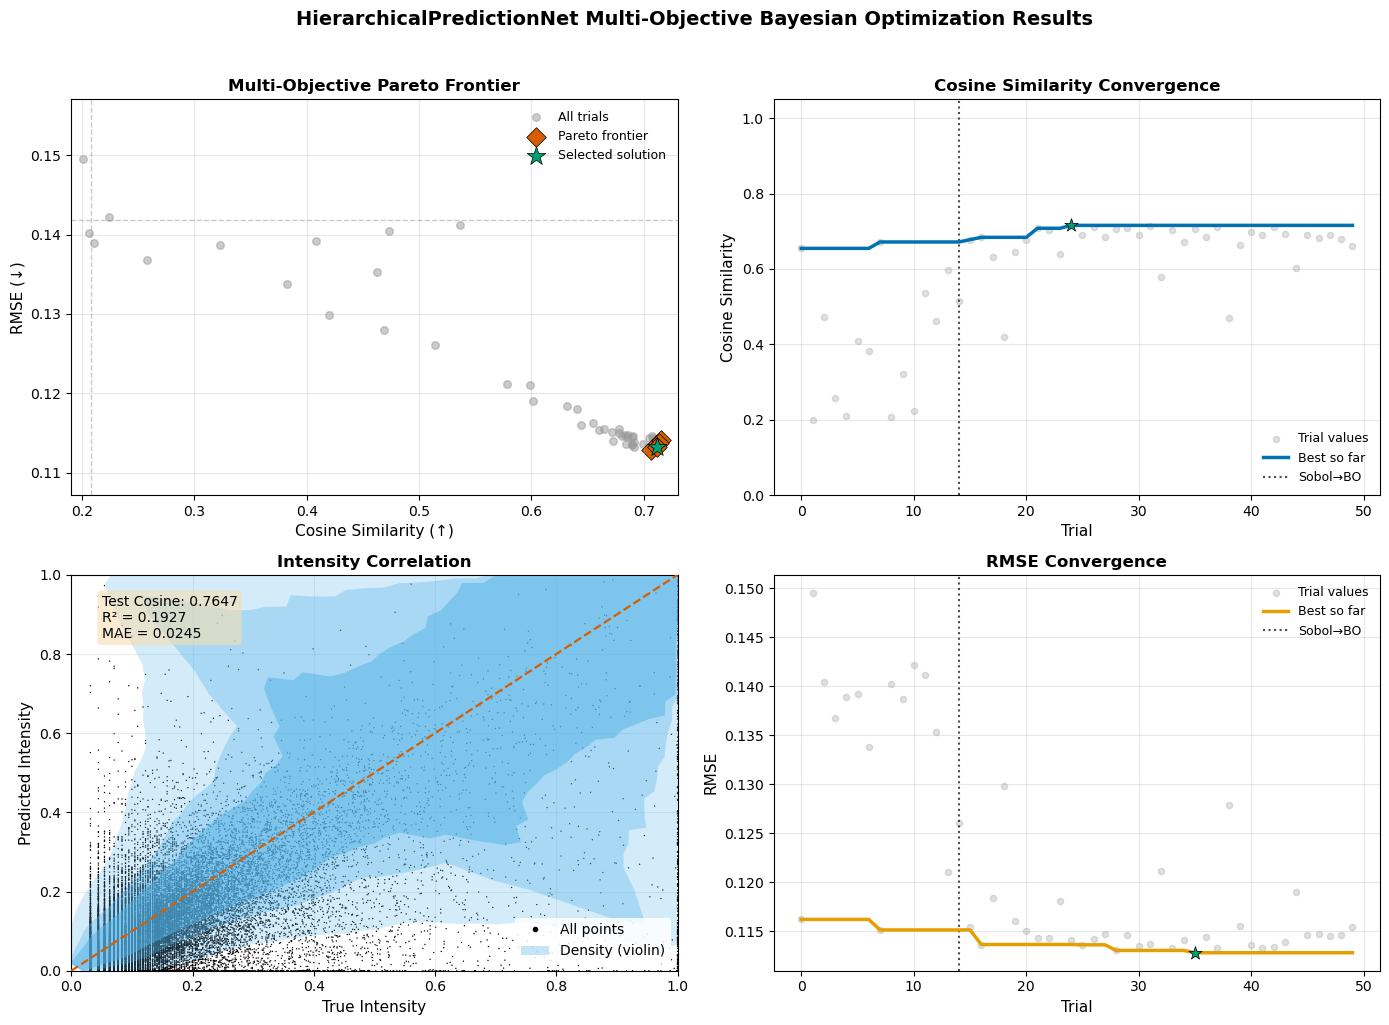

In [13]:
# ============================================================================
# OPTIMIZATION RESULTS VISUALIZATION - STANDARD 2x2 SUITE
# ============================================================================

# Colorblind-friendly Okabe–Ito palette (from standard plots)
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

# Set white background style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---------- Top-Left: Pareto Frontier ----------
ax = axes[0, 0]
ax.scatter(df_trials['cosine_similarity'], df_trials['rmse'], 
          alpha=0.5, color=PALETTE["grey"], s=30, label='All trials')
if len(pareto_trials) > 0:
    ax.scatter(pareto_trials['cosine_similarity'], pareto_trials['rmse'], 
              color=PALETTE["vermillion"], s=100, marker='D', 
              edgecolor=PALETTE["black"], linewidth=0.5, label='Pareto frontier')
ax.scatter(best_trial['cosine_similarity'], best_trial['rmse'], 
          color=PALETTE["green"], s=200, marker='*', 
          edgecolor=PALETTE["black"], linewidth=0.5, label='Selected solution')
ax.axvline(cos_threshold, color=PALETTE["grey"], linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(rmse_threshold, color=PALETTE["grey"], linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Cosine Similarity (↑)', fontsize=11)
ax.set_ylabel('RMSE (↓)', fontsize=11)
ax.set_title('Multi-Objective Pareto Frontier', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim([df_trials['cosine_similarity'].min() * 0.95, 
             df_trials['cosine_similarity'].max() * 1.02])
ax.set_ylim([df_trials['rmse'].min() * 0.95, 
             df_trials['rmse'].max() * 1.05])

# ---------- Top-Right: Cosine Similarity Convergence ----------
ax = axes[0, 1]
cosine_history = df_trials['cosine_similarity'].values
best_cosine_history = np.maximum.accumulate(cosine_history)

# Plot trial values as scatter
ax.scatter(range(len(cosine_history)), cosine_history, 
          alpha=0.3, s=20, color=PALETTE["grey"], label='Trial values')
# Plot best so far as line
ax.plot(best_cosine_history, color=PALETTE["blue"], linewidth=2.5, 
        label='Best so far', zorder=5)
# Mark transition from Sobol to BO
ax.axvline(config.n_initial_points, color=PALETTE["black"], 
          linestyle=':', linewidth=1.5, alpha=0.7, label='Sobol→BO')
# Highlight best point
best_idx = np.argmax(cosine_history)
ax.scatter(best_idx, cosine_history[best_idx], color=PALETTE["green"], 
          s=100, marker='*', zorder=10, edgecolor=PALETTE["black"], linewidth=0.5)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('Cosine Similarity Convergence', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

# ---------- Bottom-Left: Intensity Correlation (Standard Style) ----------
ax = axes[1, 0]

# Prepare data for intensity correlation plot
y_true_flat = np.ravel(data['y_test']).astype(float)
y_pred_flat = np.ravel(y_test_pred).astype(float)
m = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
x = y_true_flat[m]
y = y_pred_flat[m]

# Rotate to (u,v) coordinates for violin visualization
root2 = np.sqrt(2.0)
u = (x + y) / root2
v = (y - x) / root2

# Bin along diagonal and compute quantiles
n_bins = 60
u_edges = np.linspace(u.min(), u.max(), n_bins + 1)
u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])
widths_90 = np.full(n_bins, np.nan)
widths_75 = np.full(n_bins, np.nan)
widths_60 = np.full(n_bins, np.nan)
min_count = 10

for i in range(n_bins):
    mask = (u >= u_edges[i]) & (u < u_edges[i+1])
    if np.count_nonzero(mask) >= min_count:
        abs_v = np.abs(v[mask])
        widths_60[i] = np.percentile(abs_v, 60)
        widths_75[i] = np.percentile(abs_v, 75)
        widths_90[i] = np.percentile(abs_v, 90)

# Interpolate and smooth
def _interp_nan(a):
    xidx = np.arange(a.size)
    msk = ~np.isnan(a)
    if msk.sum() < 2:
        return np.nan_to_num(a, nan=0.0)
    return np.interp(xidx, xidx[msk], a[msk])

def _smooth(a, k=5):
    if k <= 1: return a
    kernel = np.ones(k) / k
    return np.convolve(a, kernel, mode='same')

widths_60 = _smooth(_interp_nan(widths_60), 5)
widths_75 = _smooth(_interp_nan(widths_75), 5)
widths_90 = _smooth(_interp_nan(widths_90), 5)

def band_polygon(u_vals, w_vals):
    x_upper = (u_vals - w_vals) / root2
    y_upper = (u_vals + w_vals) / root2
    x_lower = (u_vals + w_vals) / root2
    y_lower = (u_vals - w_vals) / root2
    x_poly = np.r_[x_upper, x_lower[::-1]]
    y_poly = np.r_[y_upper, y_lower[::-1]]
    return x_poly, y_poly

# Scatter points
ax.scatter(x, y, s=4, marker='.', color=PALETTE["black"],
           edgecolors='none', alpha=1.0, zorder=0, rasterized=True)

# Draw violin bands
for w, a in [(widths_90, 0.25), (widths_75, 0.35), (widths_60, 0.5)]:
    xp, yp = band_polygon(u_centers, w)
    ax.fill(xp, yp, color=PALETTE["sky"], alpha=a, edgecolor='none', zorder=2)

# Perfect prediction line
max_val = 1.0  # Clip to 1 as standard
ax.plot([0, max_val], [0, max_val], color=PALETTE["vermillion"],
        linestyle='--', linewidth=1.6, label='Perfect Prediction', zorder=4)

ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('True Intensity', fontsize=11)
ax.set_ylabel('Predicted Intensity', fontsize=11)
ax.set_title('Intensity Correlation', fontsize=12, fontweight='bold')

# Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
violin_handle = Patch(facecolor=PALETTE["sky"], alpha=0.35, edgecolor='none', label='Density (violin)')
points_handle = Line2D([0], [0], linestyle='none', marker='.', markersize=6,
                       color=PALETTE["black"], label='All points')
ax.legend(handles=[points_handle, violin_handle], loc='lower right',
          frameon=True, facecolor='white', framealpha=0.85, edgecolor='none')
ax.grid(alpha=0.25)

# Metrics annotation
test_cosine = test_metrics['cosine_similarity']
test_r2 = test_metrics['r2']
test_mae = test_metrics['mae']
text = f"Test Cosine: {test_cosine:.4f}\nR² = {test_r2:.4f}\nMAE = {test_mae:.4f}"
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10,
        va='top', bbox=dict(boxstyle='round', facecolor='wheat',
        alpha=0.6, edgecolor='none'), zorder=5)

# ---------- Bottom-Right: RMSE Convergence ----------
ax = axes[1, 1]
rmse_history = df_trials['rmse'].values
best_rmse_history = np.minimum.accumulate(rmse_history)

# Plot trial values as scatter
ax.scatter(range(len(rmse_history)), rmse_history, 
          alpha=0.3, s=20, color=PALETTE["grey"], label='Trial values')
# Plot best so far as line
ax.plot(best_rmse_history, color=PALETTE["orange"], linewidth=2.5, 
        label='Best so far', zorder=5)
# Mark transition
ax.axvline(config.n_initial_points, color=PALETTE["black"], 
          linestyle=':', linewidth=1.5, alpha=0.7, label='Sobol→BO')
# Highlight best point
best_idx = np.argmin(rmse_history)
ax.scatter(best_idx, rmse_history[best_idx], color=PALETTE["green"], 
          s=100, marker='*', zorder=10, edgecolor=PALETTE["black"], linewidth=0.5)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('RMSE Convergence', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)

# Overall title
plt.suptitle('HierarchicalPredictionNet Multi-Objective Bayesian Optimization Results', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(config.models_dir / 'hierarchical_predictionnet_optimization_results.png', 
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 14. Save Results

Save the optimized model and results for future use.

In [14]:
# Prepare results dictionary
optimization_results = {
    'best_parameters': best_params,
    'best_validation_metrics': {
        'cosine_similarity': best_trial['cosine_similarity'],
        'rmse': best_trial['rmse']
    },
    'test_metrics': test_metrics,
    'pareto_frontier': pareto_trials.to_dict('records') if len(pareto_trials) > 0 else [],
    'all_trials': df_trials.to_dict('records'),
    'optimization_time': optimization_time,
    'training_time': train_time,
    'config': vars(config),
    'model_stats': {
        'total_params': total_params,
        'trainable_params': trainable_params
    }
}

# Save model
model_path = config.models_dir / 'optimized_hierarchical_nn_model.pth'
torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_config': best_params,
    'scaler': data['final_scaler'],
    'test_metrics': test_metrics
}, model_path)
logger.info(f"Model saved to {model_path}")

# Save optimization results
results_path = config.models_dir / 'optimization_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(optimization_results, f)
logger.info(f"Results saved to {results_path}")

# Save results as JSON for portability
json_path = config.models_dir / 'optimization_results.json'
with open(json_path, 'w') as f:
    json.dump(optimization_results, f, indent=2, default=str)
logger.info(f"Results saved to {json_path}")

# Generate summary report
report_path = config.models_dir / 'optimization_report.txt'
with open(report_path, 'w') as f:
    f.write("HIERARCHICALPREDICTIONNET MULTI-OBJECTIVE BAYESIAN OPTIMIZATION REPORT\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("OPTIMIZATION CONFIGURATION\n")
    f.write("-" * 30 + "\n")
    f.write(f"Total trials: {config.n_iterations}\n")
    f.write(f"Initial points (Sobol): {config.n_initial_points}\n")
    f.write(f"Subsample fraction: {config.row_subsample_frac}\n")
    f.write(f"Max bins for eval: {config.max_bins_eval}\n")
    f.write(f"Optimization time: {optimization_time:.1f}s\n\n")
    
    if 'cos_threshold' in locals():
        f.write("OBJECTIVE THRESHOLDS\n")
        f.write("-" * 30 + "\n")
        f.write(f"Cosine similarity >= {cos_threshold:.4f}\n")
        f.write(f"RMSE <= {rmse_threshold:.4f}\n\n")
    
    f.write("BEST HYPERPARAMETERS\n")
    f.write("-" * 30 + "\n")
    f.write(f"Presence Network:\n")
    f.write(f"  Layers: {best_params['presence_layers']}\n")
    f.write(f"  Hidden units: {best_params['presence_hidden']}\n")
    f.write(f"  Dropout: {best_params['presence_dropout']:.3f}\n")
    f.write(f"Intensity Network:\n")
    f.write(f"  Layers: {best_params['intensity_layers']}\n")
    f.write(f"  Hidden units: {best_params['intensity_hidden']}\n")
    f.write(f"  Dropout: {best_params['conditional_dropout']:.3f}\n")
    f.write(f"Architecture:\n")
    f.write(f"  Activation: {best_params['activation']}\n")
    f.write(f"  Batch norm: {best_params['use_batch_norm']}\n")
    f.write(f"  Calibration: {best_params['use_calibration']}\n")
    f.write(f"Training:\n")
    f.write(f"  Optimizer: {best_params['optimizer']}\n")
    f.write(f"  Learning rate: {best_params['learning_rate']:.1e}\n")
    f.write(f"  Batch size: {best_params['batch_size']}\n")
    f.write(f"  Weight decay: {best_params['weight_decay']:.4f}\n")
    
    f.write("\nPERFORMANCE METRICS\n")
    f.write("-" * 30 + "\n")
    f.write(f"Validation Cosine (subsample): {best_trial['cosine_similarity']:.6f}\n")
    f.write(f"Validation RMSE (subsample): {best_trial['rmse']:.6f}\n")
    f.write(f"Validation Cosine (full): {full_eval['cosine_similarity'][0]:.6f}\n")
    f.write(f"Validation RMSE (full): {full_eval['rmse'][0]:.6f}\n")
    f.write(f"Test Cosine: {test_metrics['cosine_similarity']:.6f}\n")
    f.write(f"Test RMSE: {test_metrics['rmse']:.6f}\n")
    f.write(f"Test MAE: {test_metrics['mae']:.6f}\n")
    f.write(f"Test R²: {test_metrics['r2']:.6f}\n")
    f.write(f"Presence Accuracy: {test_metrics['presence_accuracy']:.6f}\n")
    f.write(f"Conditional MSE: {test_metrics['conditional_mse']:.6f}\n")
    
    f.write("\nPARETO FRONTIER\n")
    f.write("-" * 30 + "\n")
    f.write(f"Number of Pareto-optimal solutions: {len(pareto_trials)}\n")
    if len(pareto_trials) > 0:
        f.write(f"Cosine range: [{pareto_trials['cosine_similarity'].min():.4f}, "
               f"{pareto_trials['cosine_similarity'].max():.4f}]\n")
        f.write(f"RMSE range: [{pareto_trials['rmse'].min():.4f}, "
               f"{pareto_trials['rmse'].max():.4f}]\n")
    
    f.write("\nMODEL ARCHITECTURE\n")
    f.write("-" * 30 + "\n")
    f.write(f"Total parameters: {total_params:,}\n")
    f.write(f"Trainable parameters: {trainable_params:,}\n")

logger.info(f"Report saved to {report_path}")

print("\n" + "=" * 60)
print("OPTIMIZATION COMPLETE")
print("=" * 60)
print(f"Optimization time: {optimization_time:.1f}s ({optimization_time/60:.1f} minutes)")
print(f"Training time: {train_time:.1f}s")
print(f"\nBest validation performance:")
print(f"  Cosine Similarity: {best_trial['cosine_similarity']:.6f}")
print(f"  RMSE: {best_trial['rmse']:.6f}")
print(f"\nTest set performance:")
print(f"  Cosine Similarity: {test_metrics['cosine_similarity']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  Presence Accuracy: {test_metrics['presence_accuracy']:.6f}")
print(f"\nPareto frontier contains {len(pareto_trials)} solutions")
print(f"Model has {total_params:,} parameters")
print(f"All results saved to {config.models_dir}")

2025-08-25 18:27:32,585 - INFO - Model saved to ../models/hierarchical_bayesian_optimized/optimized_hierarchical_nn_model.pth
2025-08-25 18:27:32,587 - INFO - Results saved to ../models/hierarchical_bayesian_optimized/optimization_results.pkl
2025-08-25 18:27:32,594 - INFO - Results saved to ../models/hierarchical_bayesian_optimized/optimization_results.json
2025-08-25 18:27:32,604 - INFO - Report saved to ../models/hierarchical_bayesian_optimized/optimization_report.txt



OPTIMIZATION COMPLETE
Optimization time: 4153.7s (69.2 minutes)
Training time: 530.6s

Best validation performance:
  Cosine Similarity: 0.712147
  RMSE: 0.113258

Test set performance:
  Cosine Similarity: 0.764745
  RMSE: 0.070186
  Presence Accuracy: 0.869735

Pareto frontier contains 4 solutions
Model has 1,468,000 parameters
All results saved to ../models/hierarchical_bayesian_optimized
